In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import operator

Importing Libraries

In [2]:
directory = '/Users/chuamelia/Google Drive/Fall 2019/\
Introduction to Data Science/Term Project/\
Group Term Project/YouTube Video View Analysis/'

def load_obj(fname):
    # This loads the pickled object.
    with open(directory + fname + '.pkl', 'rb') as f:
        return pickle.load(f)   


In [3]:
freq = load_obj('data/bzfd_tag_freq_20191031-3142')

In [4]:
data_csv_fname = "../data/finalized_bzfd_data.csv"
processed_data_fname = "data/bzfd_processed_data_20191031-1233"

bzfd_df = pd.read_csv(data_csv_fname, sep=',', index_col=0)

In [5]:
# Table 1.
sorted_freq = sorted(freq.items(), key=operator.itemgetter(1))
sorted_freq[-5:]

[('food', 881),
 ('funny', 1726),
 ('video', 2265),
 ('buzzfeedvideo', 4902),
 ('buzzfeed', 5129)]

In [6]:
# Table 1.
bzfd_df['publishedAt'].min(), bzfd_df['publishedAt'].max()

('2012-07-03 18:42:12.000000', '2019-10-26 15:00:04.000000')

In [7]:
# Table 1.
bzfd_df.groupby('dayOfWeekPublishedAt')['videoId'].count()

dayOfWeekPublishedAt
Friday        982
Monday        736
Saturday     1110
Sunday        831
Thursday      942
Tuesday       910
Wednesday     907
Name: videoId, dtype: int64

In [8]:
# Table 2.
bzfd_df[['viewCount','titleLength','durationInSeconds']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
viewCount,6400.0,2.497455e+06,3.987847e+06,21124.0,497564.25,1069099.5,2828218.5,75660174.0
titleLength,6418.0,4.048348e+01,1.343938e+01,8.0,32.00,39.0,47.0,100.0
durationInSeconds,6418.0,2.499092e+02,3.534934e+02,24.0,111.00,173.0,296.0,11990.0


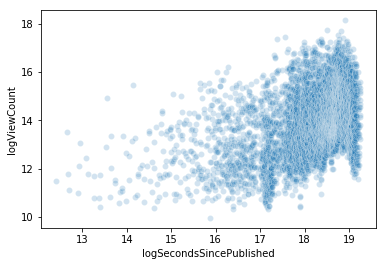

In [9]:
%matplotlib inline 
# Figure 3. Relationship Between log(viewCount) and log(secondsSincePublished)
sns.scatterplot(bzfd_df['logSecondsSincePublished'], bzfd_df['logViewCount'],  alpha=0.2)
# Around 1.5 something happens? Before/After 1.5 time matters less?
# Buzzfeed got good at videos at 1.5?

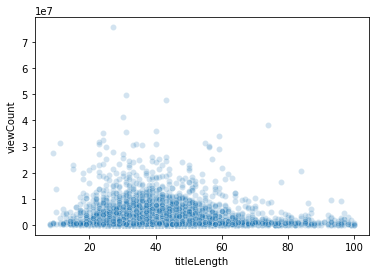

In [10]:
%matplotlib inline
# Figure 4a.  Total Number of Views vs. Title Length
sns.scatterplot(bzfd_df['titleLength'], bzfd_df['viewCount'],  alpha=0.2)

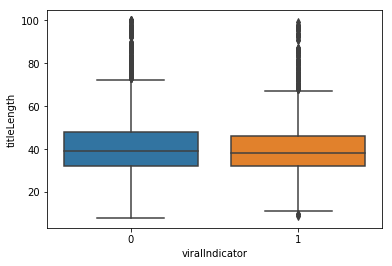

In [11]:
# Figure 4b. Distribution of Title Length by Viral Indicator
sns.boxplot(x="viralIndicator", y="titleLength", data=bzfd_df)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import train_test_split, KFold, cross_val_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
y = bzfd_df['viralIndicator']
X = bzfd_df.iloc[:,20:-1]

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=519)

In [16]:
# saved_models = [('LR',),('SVM',),('RFC',),('DT',)]
# fitted_models = {}
# for m in saved_models:
#   fitted_models[m[0]] = load_obj(m[1])

models = { 
    'LR': LogisticRegression(**{'C':1, 'solver':'sag', 
                                'random_state':519}),
    'SVM': SVC(**{'kernel':'rbf', 'C':0.1,
                  'gamma':'scale', 'random_state':519}),
    'RFC': RandomForestClassifier(**{'criterion':'entropy','min_samples_leaf':20, 
                                    'min_samples_split':24,'n_estimators':115, 
                                    'random_state':519}),
    'DT': DecisionTreeClassifier(**{'criterion':'entropy','min_samples_leaf':16, 
                                    'min_samples_split': 267,'max_depth':20, 
                                    'random_state':519})
}

fitted_models = {}
model_results = {}

pred_results = {}

In [17]:
for m in models.keys():
    model = models[m]
    kfold = KFold(n_splits=10)
    results = cross_val_score(model, X, y, cv=kfold)
    fitted_models[m] = model.fit(X_train, Y_train)
    
    if m in ['LR','RFC', 'DT']:
        prediction = fitted_models[m].predict_proba(X_test)[:,1]
    if m == 'SVM':
        prediction = fitted_models[m].decision_function(X_test)
    
    pred_results[m] = prediction

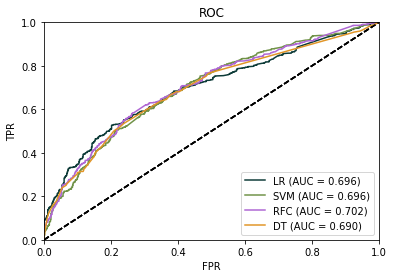

In [20]:
for model in models.keys():
    predictions = pred_results[model]
    plotUnivariateROC(predictions, Y_test, model)

In [19]:
def plotUnivariateROC(preds, truth, label_string):
    '''
    This is a UDF from the AUC Lab in Class
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    # Call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    # Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    # we are doing this as a special case because we are sending unfitted predictions
    # into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    # chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    # create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

In [8]:
# Not all videos are tagged properly
bzfd_df[bzfd_df['title'].str.startswith('People Who Don’t Cook') ]['processedTags']

185    ['buzzfeedvideo', 'buzzfeed']
Name: processedTags, dtype: object